## GAN with adaptive discriminator  augmentation (GAN-ADA)

**Author:** Luis Leal

Based on:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds

In [3]:
NUM_EPOCHS = 100
IMAGE_SIZE = 64

# resolution of Kernel Inception Distance
KID_IMAGE_SIZE = 750
PADDING = 0.25
DATASET_NAME = "caltech_birds2011"

# Adaptive discriminator augmentation
MAX_TRANSLATION =0.125
MAX_ROTATION =0.125
MAX_ZOOM =0.25
TARGET_ACCURACY = 0.85
INTEGRATION_STEPS = 1000

# architecture
NOISE_SIZE = 64
DEPTH = 4
WIDTH = 128
LRELU_ALPHA = 0.2
DROPOUT_RATE =0.4

# Training
BATCH_SIZE = 64
LEARNING_RATE = 0.0002
BETA_1 = 0.5 # important param (instead of the default of 0.9)
EMA = 0.99

## Data

The dataset is caltech birds

In [4]:
def round_to_int(value):
    return tf.cast(tf.math.round(value),dtype=tf.int32)

def preprocess_image(data):
    # unormalize bounding box coordinates(from relative to absolute coordinates)
    height = tf.cast(tf.shape(data["image"])[0], dtype=tf.float32)
    width =  tf.cast(tf.shape(data["image"])[1], dtype=tf.float32)
    bounding_box = data["bbox"] * tf.stack([height, width, height, width])
    
    print(bounding_box)
    
    # calculate center of lenght of longer side, add padding
    target_center_y = 0.5 * (bounding_box[0] + bounding_box[2])
    target_center_x = 0.5 * (bounding_box[1] + bounding_box[3])
    target_size = tf.maximum(
        (1.0 + PADDING) * (bounding_box[2] - bounding_box[0]),
        (1.0 + PADDING) * (bounding_box[3]-  bounding_box[1])
    )
    
    print(target_size)
    
    # calculate target sizes for c crop
    target_height = tf.reduce_min([target_size, 2.0 * target_center_y, 2.0* (height - target_center_y)])
    target_width = tf.reduce_min([target_size, 2.0 * target_center_x, 2.0 * (width - target_center_x)])
    
    # crop image
    image = tf.image.crop_to_bounding_box(
        data["image"],
        offset_height=round_to_int(target_center_y - 0.5*target_height),
        offset_width=round_to_int(target_center_x -0.5*target_width),
        target_height=round_to_int(target_height),
        target_width=round_to_int(target_width)
    )
    
    # resize and standarize to 0-1 interval
    image = tf.image.resize(
        image, size=[IMAGE_SIZE, IMAGE_SIZE], method = tf.image.ResizeMethod.AREA
    )
    
    image = tf.clip_by_value(image/255.0, 0.0, 1.0)
    
    return image

def prepare_dataset(split):
    
    return (
        tfds.load(DATASET_NAME, split = split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)
        .cache()
        .shuffle(10 * BATCH_SIZE)
        .batch(BATCH_SIZE, drop_remainder=True)
        .prefetch(buffer_size = tf.data.AUTOTUNE)
    )

train_dataset = prepare_dataset("train")
val_dataset = prepare_dataset("test")

Tensor("mul:0", shape=(4,), dtype=float32)
Tensor("Maximum:0", shape=(), dtype=float32)
Tensor("mul:0", shape=(4,), dtype=float32)
Tensor("Maximum:0", shape=(), dtype=float32)


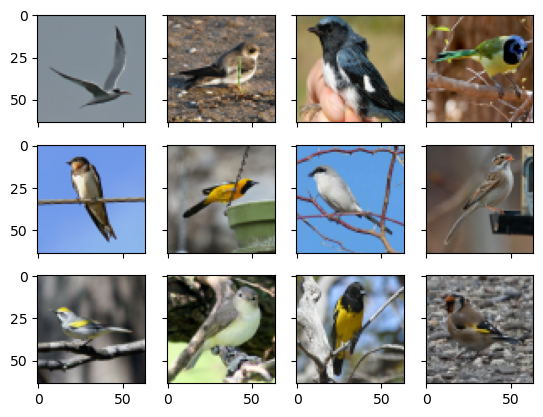

In [5]:
image_grid_rows = 3
image_grid_columns = 4
fig, axs = plt.subplots(image_grid_rows, image_grid_columns,
                           #figsize=(2.0*image_grid_rows,2.0*image_grid_columns),
                            sharey=True,
                            sharex =True
                           )

for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            
            axs[i,j].imshow(train_dataset.prefetch(64).as_numpy_iterator().next()[0],cmap="gray")
            #axs[i,j].axis("off")
            #axs[i,j].set_title(f"Digit: {labels[cnt]}")

## Evaluation via Kernel Inception Distance(KID)

One feature of generative models is that evaluation metrics(ex: training losses) not always are correlated with generated image quality, and evaluation was many times performed via human inspection of a sample of generated images as the training goes on. Some techniques exists to solve this issue:

* [Frechet inception distance(FID)](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance): compares the distribution of generated images to the distribution of a sample of real images however, it does this using a hidden layer of a pre-trained inception network under the hyphotesis that the layer computes semantic features that  have a Gaussian distribution.
It has the limitation that it is statistically biases meaning the expected value is not the same as the real value, because of this KID was introduced. 
* [Kernel inception distance(KID)](https://arxiv.org/abs/1801.01401): this is not parametric(in the statistical sense, meaning it relaxes the Gausian assumption), it uses a polynomial kernel as similarity measure(similar to kernel methods like SVMs) to measure the Maximum Mean Discrepancy(MMD)

See this reference: https://arxiv.org/pdf/2206.10935.pdf

In [6]:
class KID(keras.metrics.Metric):
    def __init__(self,name="kid",**kwargs):
        super().__init__(name=name,**kwargs)
        
        # KID is stimated per batch, and then averaged across batches
        self.kid_tracker = keras.metrics.Mean()
        
        self.encoder = keras.Sequential(
            [
                # preprocess the images for inceptionv3 accordingly(size and pixel value range, normalize)
                layers.InputLayer(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=KID_IMAGE_SIZE, width=KID_IMAGE_SIZE),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                # use a pre-trained inception as feature extractor(transfer learning)
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(KID_IMAGE_SIZE,KID_IMAGE_SIZE,3),
                    weights="imagenet"
                ),
                layers.GlobalAveragePooling2D()
            ],
            name="inception_encoder"
        )
        
        
        
    def polynomial_kernel(self, features_1, features_2):
        
        feature_dimensions = tf.cast(tf.shape(features_1)[1],dtype=tf.float32)
        return tf.pow((tf.matmul(features_1, tf.transpose(features_2))/feature_dimensions +1),3)
    
    def update_state(self, real_images, generated_images, sample_weight= None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training= False)
        
        # compute self polynomial kernels for both features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(generated_features,generated_features)
        
        #compute crosseed polynomail nernel
        kernel_cross = self.polynomial_kernel(real_features,generated_features)
        
        # calculate squared MMD(maximum mean discrepancy) using average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        
        mean_kernel_real = tf.reduce_sum(kernel_real*(1.0 - tf.eye(batch_size)))/(
            batch_size_f * (batch_size_f-1.0)
        )
        
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated*(1.0 - tf.eye(batch_size)))/(batch_size_f*(batch_size_f-1.0))
        
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross
        
        
        self.kid_tracker.update_state(kid)
         
        
    def result(self):
        return self.kid_tracker.result()
    
    def reset_state(self):
        self.kid_tracker.reset_state()

## Adaptive discrmininator augmentation

https://arxiv.org/pdf/2006.06676.pdf

When training  GANS overfitting of the discriminator can cause training to diverge, if the discriminator overfits it will not provide useful feedback to the generator and training will fail.

Data augmentation has shown to be helpful to combat overfitting in many types of models, so it can be helpful with GANS. ADA tries to stabilize training in scenarios with limited data by combating overfitting via data augmentation but making sure the distribution of real images is preserved for the generator intead of the distribution of augmented images because augmentation is wanted for discriminator training but is not wanted for the generator(ex: adding noise can help the discriminator but we don't want noise in the generated images).

**Keras note:** According to Keras also we have:

*Applying data augmentation to GANs however is not straightforward. Since the generator is updated using the discriminator's gradients, if the generated images are augmented, the augmentation pipeline has to be differentiable and also has to be GPU-compatible for computational efficiency. Luckily, the Keras image augmentation layers fulfill both these requirements, and are therefore very well suited for this task.*

### How the augmentation adapts to the training

#### TARGET_ACCURACY

The probability of using augmented images changes in order to keep the discriminator's accuracy(for real images) cloase to a desired target value(hyper-param TARGET_ACCURACY). The augmentation probability is proportional to the difference between the current accuracy and the desired target accuracy.

* if current accuracy is less than desired accuracy we reduce the probability of aumenting images
* if current accuracy is higher than the desired accuracy we increase the probability of augmenting images.

We can say that if we are doing good in real images we have some room to generate agumented images.

The authors suggest to use 80-90% range for target_accuracy

#### INTEGRATION_STEPS

This hyper-param controls the size of the updates to the augmentation probability. Kind of a learning rate but for learning the probability. In other words controls how slowly the augmentation probability is changed.

The authors suggest to use a large value like 1000 so changes are not so huge.

In [7]:
def step(values):
    """convert negative values to 0 and positive values to 1 useful for binary accuracy calculation"""
    return 0.5 *( 1.0 + tf.sign(values))

In [8]:
# augments the dataset with a probability that is dinamically updated during training

class AdaptiveAugmenter(keras.Model):
    
    def __init__(self):
        super().__init__()
        
        # this makes it "adaptive", the probability of using augmented images (instead of real)
        # it his a tf.Variable because it is a trainable parameter (will be updated during optimization)
        # gradients with respect to this probability will be calculated
        self.probability = tf.Variable(0.0)
        
        # the paper uses augmentation names, the names in the paper are added here
        # according to the paper blitting and geometric augmentations are the most helpful
        # see figure 4 in the paper
        self.augmenter = keras.Sequential([
            layers.InputLayer(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)), 
            layers.RandomFlip("horizontal"), # blitting/x-flip
            layers.RandomTranslation( #blitting/integer translation
                height_factor = MAX_TRANSLATION,
                width_factor = MAX_TRANSLATION,
                interpolation = "nearest"
            ),
            
            layers.RandomRotation(factor=MAX_ROTATION), #geometric/rotation
            
            layers.RandomZoom( # geometric/isotropic and unisotropic scaling
                height_factor=(-MAX_ZOOM,0.0),width_factor=(-MAX_ZOOM,0.0))
        ],
        name = "adaptive_augmenter"
        )
        
    def call(self, images, training):
        """Probabilistically select real images or random augmentted images"""
        if training:
            # create a batch of candiate augmented images
            augmented_images = self.augmenter(images, training)
            
            # randonly select real vs augmented images 
            # with augmented images selected with probability self.probability
            # if elf.probability == 0 only real images are selected 
            # if self.probability == 1 only augmented images are selected
            augmentation_values = tf.random.uniform(
                shape = (BATCH_SIZE,1,1,1,),minval=0.0,maxval=1.0
            )
            augmentation_bools = tf.math.less(augmentation_values, self.probability)
            
            images = tf.where(augmentation_bools, augmented_images, images)
            
        return images
    
    def update(self, real_logits):
        """adapts the augmentation probability depending on 
          the difference between current accuracy and desired accuracy
          the higher the error, the higher the probability increase
        """
        current_accuracy = tf.reduce_mean(step(real_logits))
        
        accuracy_error = current_accuracy - TARGET_ACCURACY
        self.probability.assign(
            tf.clip_by_value(self.probability + accuracy_error/INTEGRATION_STEPS,
                            0.0,1.0
                            )
        )
            

## Model and architecture

This will be a classic DC-GAN

### Generator

In [9]:
def get_generator():
    noise_input = keras.Input(shape=(NOISE_SIZE,))
    h = layers.Dense(4* 4 * WIDTH, use_bias=False)(noise_input)
    h = layers.BatchNormalization(scale=False)(h)
    h = layers.ReLU()(h)
    h = layers.Reshape(target_shape=(4,4,WIDTH))(h)
    
    for i in range(DEPTH-1):
        h = layers.Conv2DTranspose(WIDTH, kernel_size=4, strides=2, 
                                   padding="same",use_bias=False)(h)
        h = layers.BatchNormalization(scale=False)(h)
        h = layers.ReLU()(h)
        
    output_image = layers.Conv2DTranspose(3,kernel_size=4, 
                                          strides=2, padding="same",activation="sigmoid")(h)
    
    return keras.Model(noise_input, output_image, name="generator")

### Discriminator

In [10]:
def get_discriminator():
    image_input = keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    h = image_input
    
    for i in range(DEPTH):
        h = layers.Conv2D(
            WIDTH,kernel_size=4,strides=2,padding="same",use_bias=False
        )(h)
        h = layers.BatchNormalization(scale=False)(h)
        h = layers.LeakyReLU(alpha=LRELU_ALPHA)(h)
        
    h = layers.Flatten()(h)
    h = layers.Dropout(DROPOUT_RATE)(h)
    
    output_score = layers.Dense(1)(h)
    
    return keras.Model(image_input, output_score, name = "discriminator")

### GAN

In [11]:
class GAN_ADA(keras.Model):
    def __init__(self):
        super().__init__()
        
        self.augmenter = AdaptiveAugmenter()
        self.generator = get_generator()
        self.ema_generator = keras.models.clone_model(self.generator)
        self.discriminator = get_discriminator()
        
        print(self.generator.summary())
        print(self.discriminator.summary())
        
    def compile(self, generator_optimizer, discriminator_optimizer, **kwargs):
        super().compile(**kwargs)
        
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        
        self.generator_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.discriminator_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.real_accuracy = keras.metrics.BinaryAccuracy(name="real_acc")
        self.generated_accuracy = keras.metrics.BinaryAccuracy(name="gen_acc")
        self.augmentation_prob_tracker = keras.metrics.Mean(name="aug_prob")
        self.kid = KID()
        
    @property
    def metrics(self):
        return [
            
            self.generator_loss_tracker,
            self.discriminator_loss_tracker,
            self.real_accuracy,self.generated_accuracy,
            self.augmentation_prob_tracker,
            self.kid
        ]

    
    def generate(self,batch_size,training):
        latent_samples = tf.random.normal(shape=(batch_size,NOISE_SIZE))
        
        if training:
            generated_images = self.generator(latent_samples, training)
        else:
            generated_images = self.ema_generator(latent_samples,training)
            
        return generated_images
    
    def adversarial_loss(self, real_logits, generated_logits):
        
        real_labels = tf.ones(shape=(BATCH_SIZE,1))
        generated_labels = tf.zeros(shape=(BATCH_SIZE,1))
        
        # the generator's objective is to produce images that look real(compare to 1s)
        generator_loss = tf.keras.losses.binary_crossentropy(
            real_labels,generated_logits,from_logits=True
        )
        
        # the discriminator's objective is to discriminate real from generated images
        ## we create a single dataset containing both real and generated by concatenation
        discriminator_loss = keras.losses.binary_crossentropy(
            tf.concat([real_labels,generated_labels],axis=0),
            tf.concat([real_logits, generated_logits],axis=0),
            from_logits = True
        )
        
        return tf.reduce_mean(generator_loss), tf.reduce_mean(discriminator_loss)
    def train_step(self, real_images):
        real_images = self.augmenter(real_images, training=True) 
        
        with tf.GradientTape(persistent=True) as tape:
            generated_images = self.generate(BATCH_SIZE, training=True)
            
            # need to calculate gradient through augmentation (see keras nmte in this notebook)
            generated_images = self.augmenter(generated_images,training=True)
            
            # forward propagation separetely for real and generated images so batchnorm uses different statistic
            real_logits = self.discriminator(real_images, training=True)
            generated_logits = self.discriminator(generated_images, training=True)
            
            generator_loss, discriminator_loss = self.adversarial_loss(real_logits,generated_logits)
            
        # backpropagation and update weights
        generator_gradients = tape.gradient(
            generator_loss, self.generator.trainable_weights
        )
        discriminator_gradients = tape.gradient(
            discriminator_loss, self.discriminator.trainable_weights
        )
        
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients,self.generator.trainable_weights)
        )
        
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_weights)
        )
        
        # now "train"  the augmentation probability for the adaptive augmenter
        self.augmenter.update(real_logits)
        
        #update the metrics for tracking
        self.generator_loss_tracker.update_state(generator_loss)
        self.discriminator_loss_tracker.update_state(discriminator_loss)
        self.real_accuracy.update_state(1.0, step(real_logits))
        self.generated_accuracy.update_state(0.0,step(generated_logits))
        self.augmentation_prob_tracker.update_state(self.augmenter.probability)
        
        # the following exponential moving average of generator's weights decreaces variance in 
        # generated quality
        
        for weight, ema_weight in zip(self.generator.weights, self.ema_generator.weights):
            ema_weight.assign(EMA * ema_weight + (1-EMA)*weight)
            
        # kernel inception distance is not captured during training(only testing) for computational purposes
        return {m.name: m.result() for m in self.metrics[:-1]}
    
    def test_step(self, real_images):
        generated_images = self.generate(batch_size=BATCH_SIZE, training=False)
        
        self.kid.update_state(real_images, generated_images)
        
        #for metric in self.metrics:
        #    metric.update_state(real_images, generated_images)
        
        return  {m.name: m.result() for m in self.metrics}
    
    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6, interval=20):
        
        # visualize a sample of generated images
        if epoch is None or (epoch+1) % interval == 0:
            num_images = num_rows * num_cols
            generated_images = self.generate(num_images,training=False)
            
            plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
            
            for row in range(num_rows):
                for col in range(num_cols):
                    index = row * num_cols + col
                    plt.subplot(num_rows, num_cols, index +1)
                    plt.imshow(generated_images[index])
                    plt.axis("off")
                    
            plt.tight_layout()
            plt.show()
            plt.close()

## Training

Keep an eye on the discriminator's accuracy for real images, if the accuracy is below the desired accuracy the augmentation probability has to increase, if the accuracy is above the desired accuracyu the augmentation probability should decrease. Authors suggest a correct training should keep the disc. accuracy on real images around 90-95% range, below that the disc. is underfittin above that is overfitting.

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense (Dense)               (None, 2048)              131072    
                                                                 
 batch_normalization (BatchN  (None, 2048)             6144      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        262144    
 nspose)                                                 

2023-05-29 12:57:08.612172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/adaptive_augmenter/SelectV2_1-1-TransposeNHWCToNCHW-LayoutOptimizer


93/93 [==============================] - 148s 2s/step - g_loss: 3.9622 - d_loss: 0.1529 - real_acc: 0.9351 - gen_acc: 0.9597 - aug_prob: 0.0044 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.1435
Epoch 2/100
93/93 [==============================] - 125s 1s/step - g_loss: 4.1455 - d_loss: 0.1226 - real_acc: 0.9565 - gen_acc: 0.9651 - aug_prob: 0.0148 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.1568
Epoch 3/100
93/93 [==============================] - 126s 1s/step - g_loss: 4.1041 - d_loss: 0.1427 - real_acc: 0.9528 - gen_acc: 0.9619 - aug_prob: 0.0242 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.1485
Epoch 4/100
93/93 [==============================] - 126s 1s/step - g_loss: 4.4470 - d_loss: 0.0833 

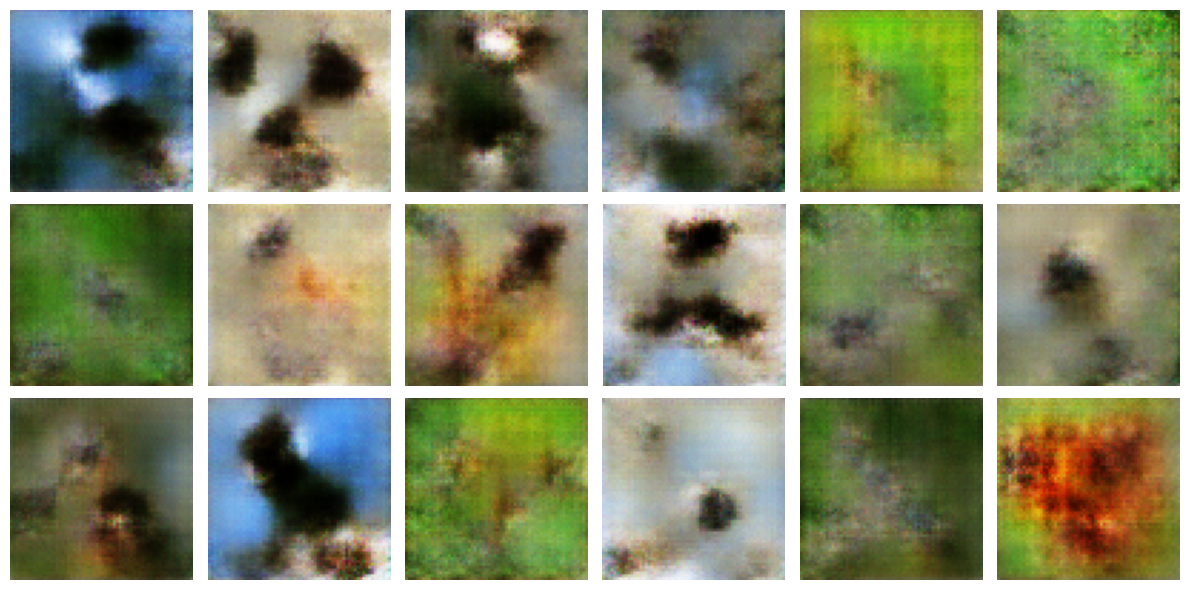

93/93 [==============================] - 128s 1s/step - g_loss: 2.9641 - d_loss: 0.2690 - real_acc: 0.8992 - gen_acc: 0.9056 - aug_prob: 0.1227 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.0573
Epoch 21/100
93/93 [==============================] - 127s 1s/step - g_loss: 2.8558 - d_loss: 0.2748 - real_acc: 0.8898 - gen_acc: 0.8980 - aug_prob: 0.1261 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.0527
Epoch 22/100
93/93 [==============================] - 126s 1s/step - g_loss: 3.0789 - d_loss: 0.2577 - real_acc: 0.8942 - gen_acc: 0.8942 - aug_prob: 0.1304 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.0514
Epoch 23/100
93/93 [==============================] - 126s 1s/step - g_loss: 2.9332 - d_loss: 0.21

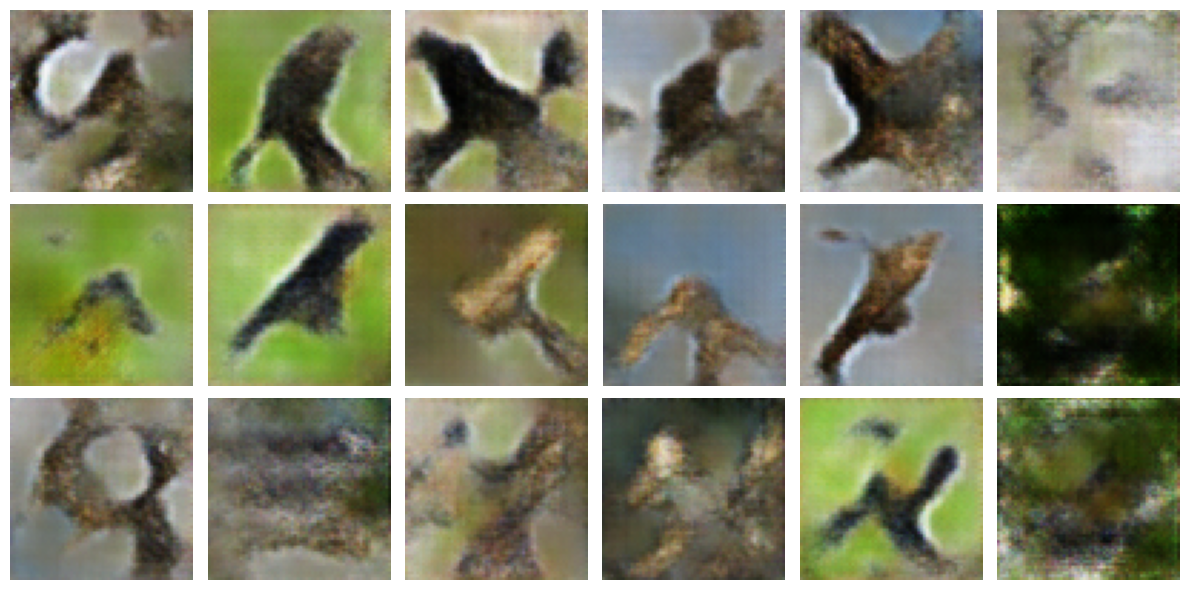

93/93 [==============================] - 127s 1s/step - g_loss: 3.3772 - d_loss: 0.2757 - real_acc: 0.8898 - gen_acc: 0.8866 - aug_prob: 0.2488 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.0359
Epoch 41/100
93/93 [==============================] - 126s 1s/step - g_loss: 3.4857 - d_loss: 0.1796 - real_acc: 0.9341 - gen_acc: 0.9296 - aug_prob: 0.2552 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.0344
Epoch 42/100
93/93 [==============================] - 127s 1s/step - g_loss: 3.2298 - d_loss: 0.2473 - real_acc: 0.9057 - gen_acc: 0.8990 - aug_prob: 0.2624 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.0322
Epoch 43/100
93/93 [==============================] - 127s 1s/step - g_loss: 3.3843 - d_loss: 0.21

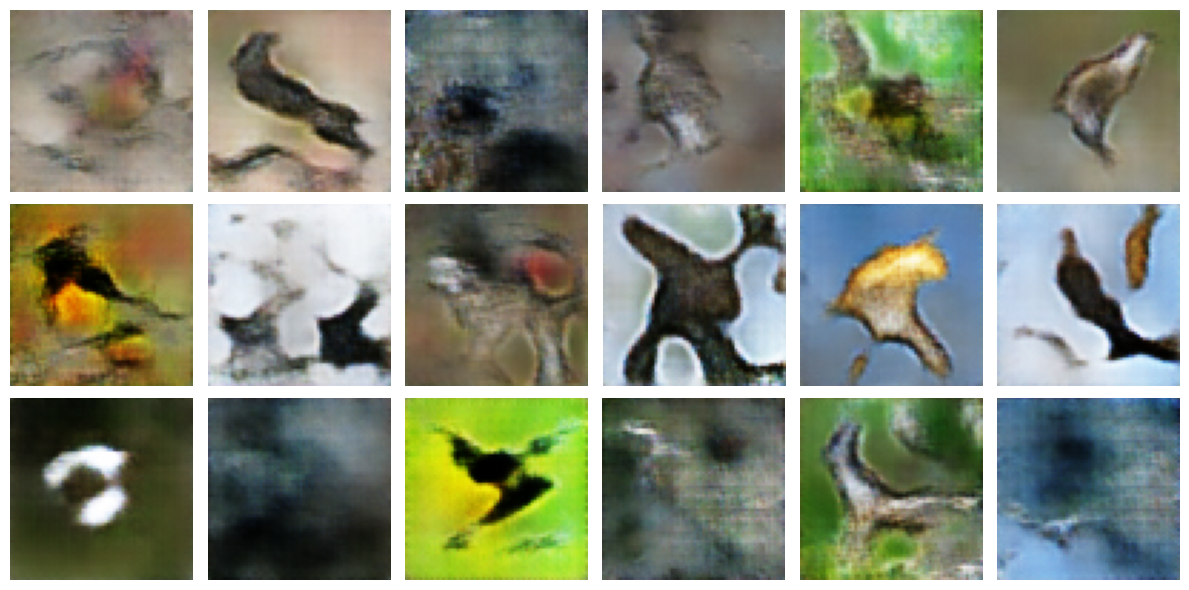

93/93 [==============================] - 127s 1s/step - g_loss: 2.9216 - d_loss: 0.2881 - real_acc: 0.8763 - gen_acc: 0.8775 - aug_prob: 0.3390 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.0226
Epoch 61/100
93/93 [==============================] - 126s 1s/step - g_loss: 3.0681 - d_loss: 0.2619 - real_acc: 0.8967 - gen_acc: 0.8945 - aug_prob: 0.3428 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.0229
Epoch 62/100
93/93 [==============================] - 127s 1s/step - g_loss: 2.8745 - d_loss: 0.3160 - real_acc: 0.8636 - gen_acc: 0.8706 - aug_prob: 0.3467 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.0209
Epoch 63/100
93/93 [==============================] - 126s 1s/step - g_loss: 2.9321 - d_loss: 0.24

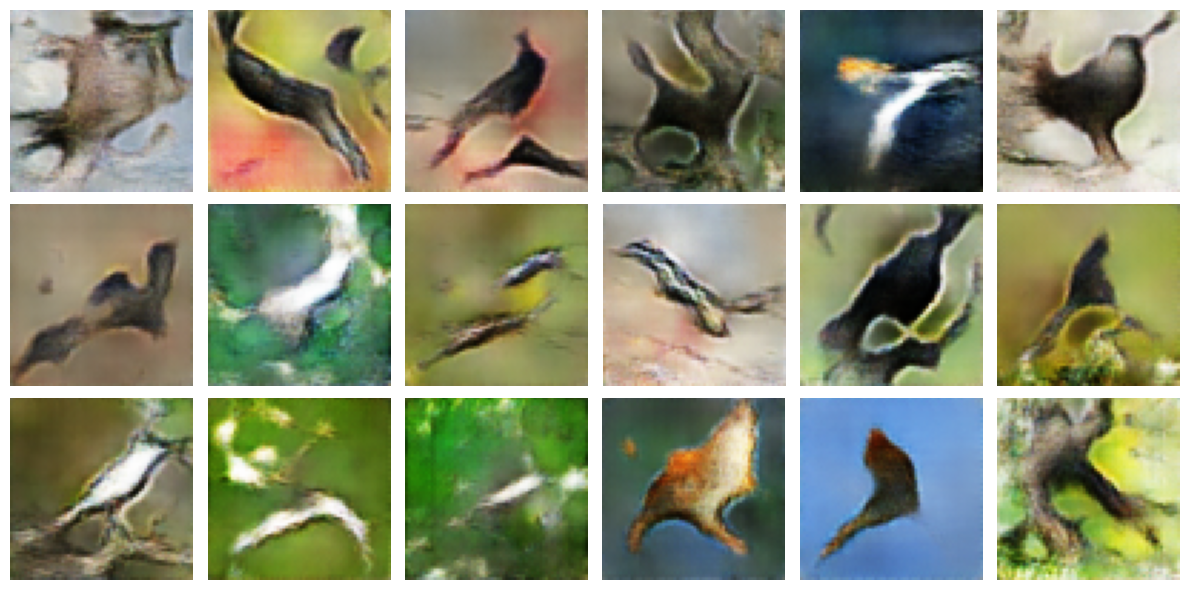

93/93 [==============================] - 127s 1s/step - g_loss: 3.0440 - d_loss: 0.2300 - real_acc: 0.9099 - gen_acc: 0.9147 - aug_prob: 0.4117 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.0169
Epoch 81/100
93/93 [==============================] - 126s 1s/step - g_loss: 2.7903 - d_loss: 0.4012 - real_acc: 0.8466 - gen_acc: 0.8525 - aug_prob: 0.4136 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.0177
Epoch 82/100
93/93 [==============================] - 126s 1s/step - g_loss: 2.7696 - d_loss: 0.2462 - real_acc: 0.9029 - gen_acc: 0.9074 - aug_prob: 0.4169 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.0171
Epoch 83/100
93/93 [==============================] - 126s 1s/step - g_loss: 2.9470 - d_loss: 0.26

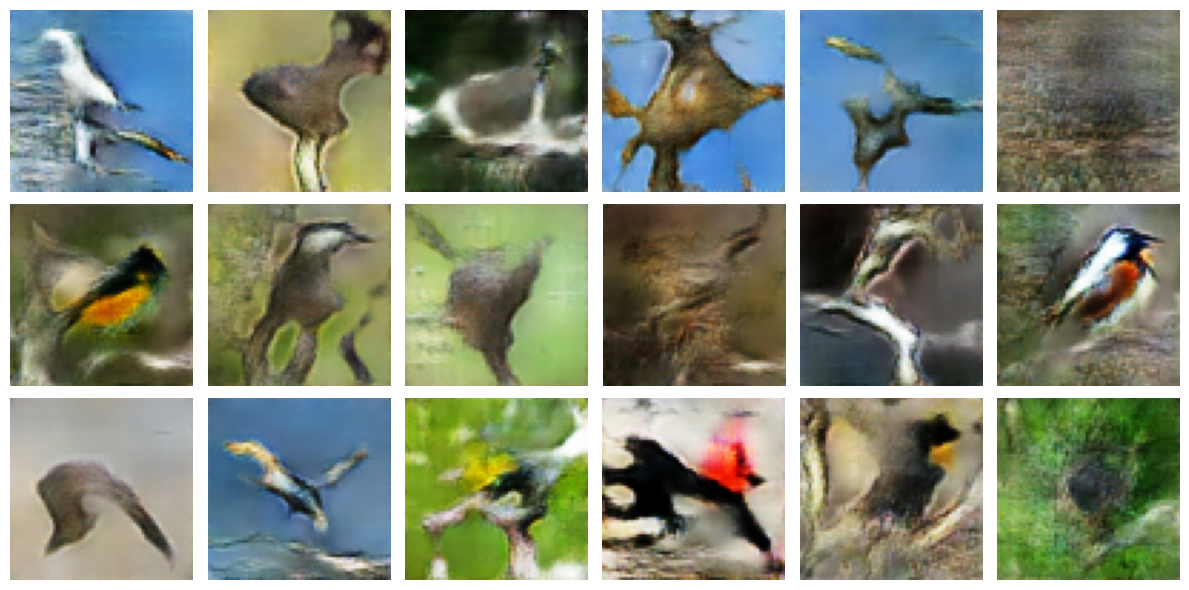

93/93 [==============================] - 127s 1s/step - g_loss: 2.9011 - d_loss: 0.2679 - real_acc: 0.8831 - gen_acc: 0.8874 - aug_prob: 0.4747 - val_g_loss: 0.0000e+00 - val_d_loss: 0.0000e+00 - val_real_acc: 0.0000e+00 - val_gen_acc: 0.0000e+00 - val_aug_prob: 0.0000e+00 - val_kid: 0.0139


In [12]:
with tf.device('/GPU:0'):
    model = GAN_ADA()
    model.compile(
        generator_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1= BETA_1),
        discriminator_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1= BETA_1)
                 )

    checkpoint_path = "gan_ada"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor="val_kid",
        mode = "min",
        save_best_only=True
    )

    model.fit(
        train_dataset,
        epochs=NUM_EPOCHS,
        validation_data=val_dataset,
        callbacks=[
            keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
            checkpoint_callback
        ]
    )


## test time

In [13]:
history = model.history

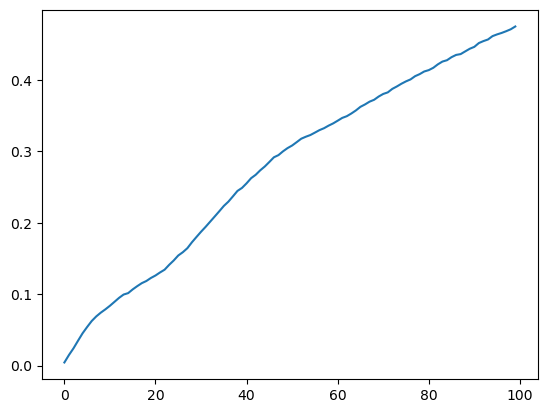

In [14]:


plt.plot(history.history["aug_prob"])
plt.show()

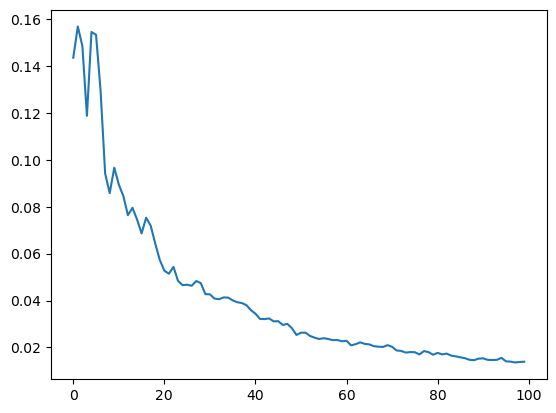

In [15]:
plt.plot(history.history["val_kid"])
plt.show()

dict_keys(['g_loss', 'd_loss', 'real_acc', 'gen_acc', 'aug_prob', 'val_g_loss', 'val_d_loss', 'val_real_acc', 'val_gen_acc', 'val_aug_prob', 'val_kid'])


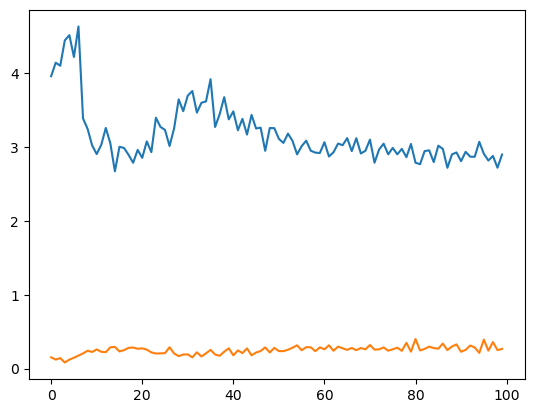

In [16]:
history = model.history

print(history.history.keys())

plt.plot(history.history["g_loss"])
plt.plot(history.history["d_loss"])
plt.show()

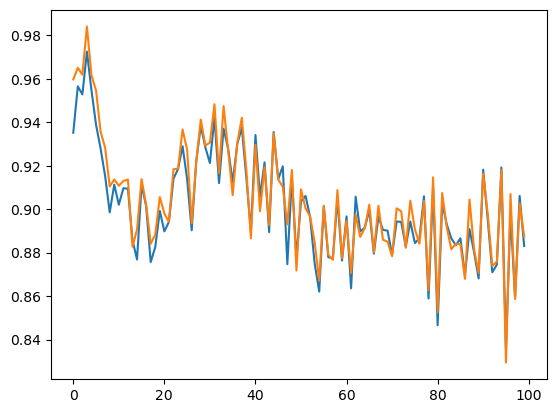

In [17]:
plt.plot(history.history["real_acc"])
plt.plot(history.history["gen_acc"])
plt.show()

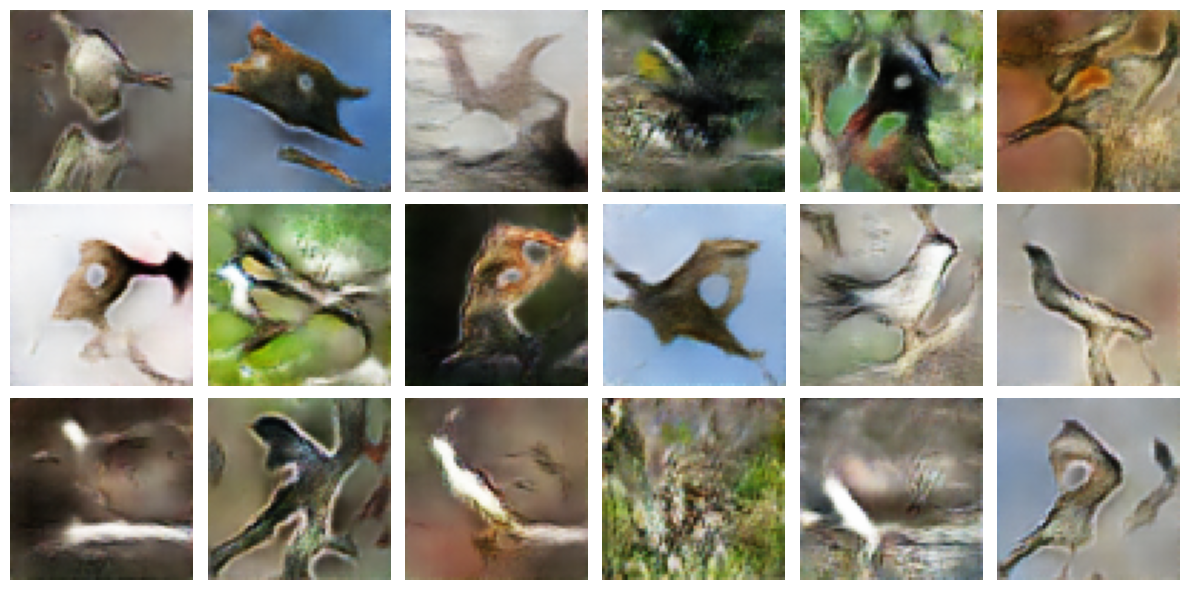

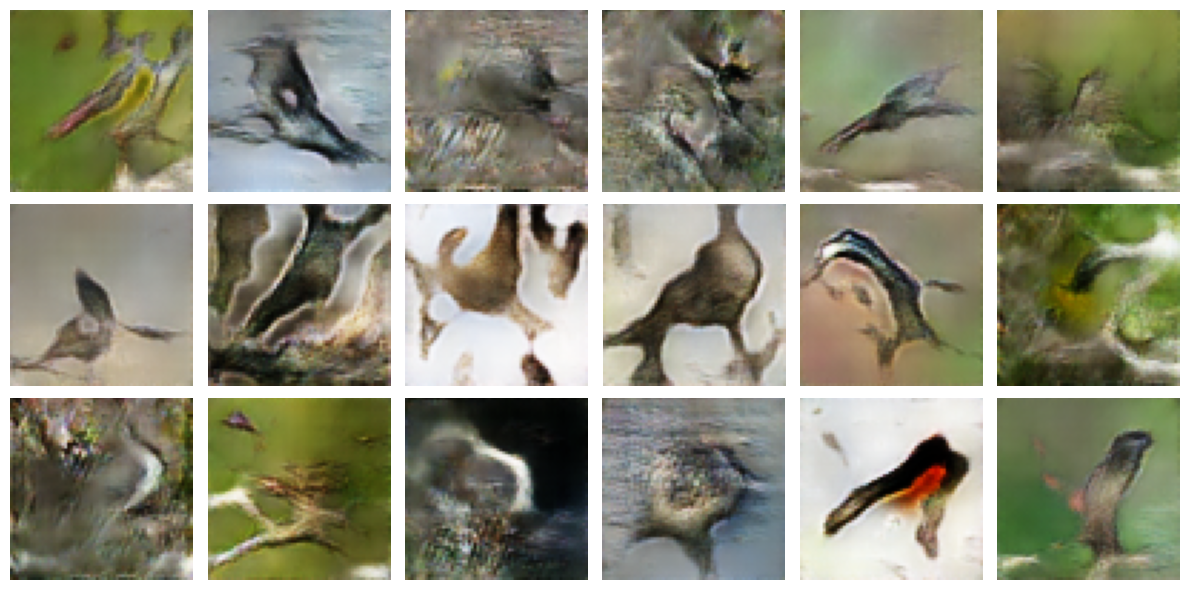

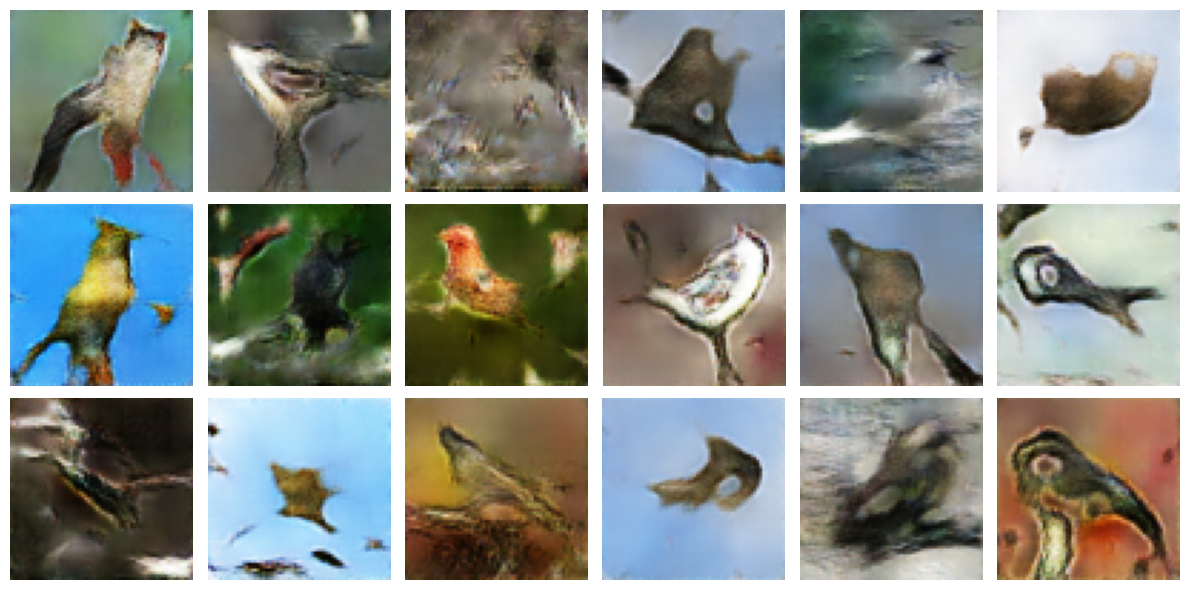

In [18]:
test_rounds = 3




for i in range(test_rounds):
    model.plot_images()

In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]